## Project_3 EDA + Feature Engineering Booking.com
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель

### Данные: 
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### 0. Подготовительный этап

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
from sklearn import preprocessing

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

### 1. Первичный анализ данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


In [8]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [9]:
data_numeric = data.select_dtypes(include=[np.number])
numeric_cols = data_numeric.columns.values
print(numeric_cols)
#numeric_cols = [s for s in data.columns if (data[s].dtypes == 'int64') | (data[s].dtypes == 'float64')]
#numeric_cols

['additional_number_of_scoring' 'average_score'
 'review_total_negative_word_counts' 'total_number_of_reviews'
 'review_total_positive_word_counts'
 'total_number_of_reviews_reviewer_has_given' 'lat' 'lng' 'sample'
 'reviewer_score']


In [10]:
data_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)
#object_cols = [s for s in data.columns if data[s].dtypes == 'object']
#object_cols

['hotel_address' 'review_date' 'hotel_name' 'reviewer_nationality'
 'negative_review' 'positive_review' 'tags' 'days_since_review']


После первичного анализа можно сделать следующие выводы:

В нашем ds 10 числовых и 8 признаков типа object.

Пропуски есть только в двух признаках: lat, lng, отвечающих за кооридинаты отеля.

### 2. Проектирование признаков и обработка пропусков

#### 2.1 Описание числовых данных

In [11]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


Посмотрев описание числовых данных, я не заметил явных проблем. Особое внимание уделил признаку reviewer_score. Он не выходит за границы от 0 до 10. 

Обработку пропусквов оставлю на потом, а по остальным числовым признакам все хорошо.

Теперь можно перейти к обработке текстовых признаков.

#### 2.2 Признак hotel_address и hotel_name

In [12]:
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [13]:
data['hotel_address'].nunique()

1493

In [14]:
# Cколько отелей с одинаковым названием имеют различный адрес
name_address = data.pivot_table(
    values = 'hotel_address',
    index = 'hotel_name',
    aggfunc = 'nunique'
)
dupl = name_address[name_address['hotel_address'] > 1]
dupl

,hotel_address
hotel_name,
Hotel Regina,3


Получается, что отель с названием Hotel Regina находится по 3-м адресам. Добавим к названию город, где он находится.

In [15]:
dupl_list = dupl[dupl['hotel_address'] > 1].index.to_list()
data['hotel_name'] = data.apply(lambda x: (x['hotel_name'] + ' in ' + x['hotel_address'].split()[-2])
    if (x['hotel_name'] in dupl_list) else x['hotel_name'], axis=1)
data['hotel_name'].nunique()

1494

In [16]:
data[data['hotel_name'].str.contains(dupl_list[0])]['hotel_name'].value_counts()

Hotel Regina in Barcelona    590
Hotel Regina in Vienna       284
Hotel Regina in Milan         60
Name: hotel_name, dtype: int64

В итоге получилось 1494 уникальных отеля в ds.

Теперь можно заняться извлечением данных из признака hotel_address.

Хочу выделить города и страны из адреса.

In [17]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data.loc[data['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'

data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [18]:
data['hotel_city'] = data['hotel_address'].apply\
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

Получилось, что у нас есть 6 стран и 6 городов. Индекс находить не вижу смысла, думаю будет достаточно информации только о городе.

In [19]:
data = data.drop(['hotel_address'],axis=1)
# Кодируем город и создаём новый признак.
data['hotel_city'] = data['hotel_city'].astype('category')
data['hotel_city_code'] = data['hotel_city'].cat.codes

In [20]:
# Кодируем город и создаём новый признак.
data['hotel_name_code'] = data['hotel_name'].astype('category').cat.codes

Теперь зная город можно заменить пропуски в координатах отеля на модальные значения координат по городу.
#### 2.3 Заполнение пропусков

In [21]:
for city in list(data['hotel_city'].unique()):
    mode_lat = data[(data['hotel_city'] == city) & data.lat > 0].lat.mode()
    mode_lng = data[(data['hotel_city'] == city) & data.lng > 0].lng.mode()
    data[data['hotel_city'] == city]['lat'] = data['lat'].fillna(mode_lat[0], inplace=True)
    data[data['hotel_city'] == city]['lng'] = data['lng'].fillna(mode_lat[0], inplace=True)
data.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
hotel_city_code                               0
hotel_name_code                         

Теперь пропусков в данных нет.

#### 2.4 Признак reviewer_nationality

In [22]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip()) #отсекаем пробелы в начале и в конце строки

Создадим признак того, остановился ли рецензент в отеле своей страны. И закодируем национальности.

In [23]:
data['is_citizen'] = data['reviewer_nationality'] == data['hotel_country']
data['is_citizen'] = data['is_citizen'].astype('int')

In [24]:
data['reviewer_nationality'].nunique()

227

In [25]:
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nationality_code'] = data['reviewer_nationality'].cat.codes
data

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_city_code,hotel_name_code,is_citizen,reviewer_nationality_code
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,45.533137,9.171102,0,0.0,Italy,Milan,3,612,0,214
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,0,1447,0,22
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,41.393192,2.161520,0,0.0,Spain,Barcelona,1,33,0,196
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,45.479888,9.196298,0,0.0,Italy,Milan,3,735,0,216
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,52.370545,4.888644,0,0.0,Netherlands,Amsterdam,0,633,0,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,...,51.494028,-0.191050,1,8.8,United Kingdom,London,2,711,0,72
515734,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,...,48.192379,16.399451,1,9.2,Austria,Vienna,5,104,0,206
515735,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,...,51.520795,-0.131084,1,8.3,United Kingdom,London,2,177,0,144
515736,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,...,51.515125,-0.160066,1,9.2,United Kingdom,London,2,1366,0,213


#### 2.5 Признак tags

In [26]:
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [27]:
# Превеобразуем теги в список

def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags'] = data['tags'].apply(re_func)

In [28]:
# Развернем во временном датасете data_copy тэги из списка в один на каждую строку
data_copy = data.explode('tags')

print ( 'Количество уникальных тегов:',len(data_copy['tags'].unique()))

Количество уникальных тегов: 2428


In [29]:
# Создадим множество из 25 самых часто встречаемых тегов

tags_counts = data_copy['tags'].value_counts()[:25]
df_tags_counts = pd.DataFrame(tags_counts).reset_index()
df_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(df_tags_counts['unique_tags'])

In [30]:
# Кодируем теги, получив новые 25 признаков
# 1 -  в отзыве есть этот тег, 0 - тега нет

for tag in top_tags:
    tag_name = str(tag)
    data[tag_name] =  data['tags'].apply(lambda x: 1 if tag_name in x else 0)

#### 2.6 Признак review_date

Преведу к типу datetime и выделю день, месяц и год отзыва.

Хочу выделить отдельно день, тк он может влиять на отзыв. Если предположить, что в какой-то из дней произошла неприятная ситуация (например шумные ремонтные работы, проблемы со светом или водой), то в этот день рейтинг будет значительно ниже модальной оценки.

In [31]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day'] = data['review_date'].dt.day

data = data.drop(['review_date'], axis = 1)

#### 2.6 Признак days_since_review

Оставлю только числовое значение кол-ва дней

In [32]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int')

#### 2.7 Признак negative_review

In [33]:
data['negative_review'].value_counts().nlargest(20)

No Negative         127890
 Nothing             14295
 Nothing              4236
 nothing              2225
 N A                  1037
 None                  984
                       849
 N a                   509
 Breakfast             407
 Small room            373
 Location              368
 Everything            326
 All good              318
 Nothing really        316
 none                  302
 nothing               283
 No complaints         274
 Price                 260
 Nothing really        254
 Nil                   247
Name: negative_review, dtype: int64

Видим , что в негативные отзывы попали "No negative, Nothing, N A, All good, none, Nothing really". Приведем все к одному регистру и исправим это.

In [34]:
data['negative_review'] = data['negative_review'].apply(lambda x : x.lower().strip())
data['negative_review'].value_counts().nlargest(20)

no negative                127890
nothing                     21185
n a                          1815
none                         1501
                              849
nothing really                656
small room                    570
all good                      545
breakfast                     545
no complaints                 523
location                      502
nothing at all                467
everything                    420
nothing to dislike            373
price                         348
nil                           332
small rooms                   307
everything was perfect        276
na                            272
can t think of anything       250
Name: negative_review, dtype: int64

In [35]:
false_neg = ['no negative','nothing','n a','none','','all good','nothing really','na','nothing to dislike']

data['new_negative_review'] = data['negative_review'].apply(lambda x : 0 if x in false_neg else 1)#вручную кодируем признак

data['new_negative_review'].value_counts()

1    360652
0    155086
Name: new_negative_review, dtype: int64

In [36]:
data = data.drop(['negative_review'], axis=1)

#### 2.8 Признак positive_review

Поступаем аналогично с негативными отзывами

In [37]:
data['positive_review'] = data['positive_review'].apply(lambda x : x.lower().strip())
data['positive_review'].value_counts().nlargest(20)

no positive                   35946
location                      11945
everything                     3314
nothing                        1731
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
Name: positive_review, dtype: int64

In [38]:
false_pos = ['no positive','nothing']
data['new_positive_review'] = data['positive_review'].apply(lambda x : 0 if x in false_pos else 1)
data['new_positive_review'].value_counts()

1    478061
0     37677
Name: new_positive_review, dtype: int64

In [39]:
data = data.drop(['positive_review'], axis=1)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515738 non-null  int64   
 1   average_score                               515738 non-null  float64 
 2   hotel_name                                  515738 non-null  object  
 3   reviewer_nationality                        515738 non-null  category
 4   review_total_negative_word_counts           515738 non-null  int64   
 5   total_number_of_reviews                     515738 non-null  int64   
 6   review_total_positive_word_counts           515738 non-null  int64   
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64   
 8   tags                                        515738 non-null  object  
 9   days_since_review                           515738 non-null

## 3. Отбор признаков

#### 3.1 Удаление признаков, которые по типу данных не подходят для построения модели

In [41]:
data_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)

['hotel_name' 'reviewer_nationality' 'tags' 'hotel_country' 'hotel_city']


In [42]:
data = data.drop(non_numeric_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Итого после подготовки данных получилось 45 признаков, из них 25 это самые популярные tag

#### 3.2 Стандартизация и нормализация

Для алгоритма Random Forrest: 'data normalization won’t affect the output for Random Forest classifiers while it will affect the output for Random Forest regressors.

Мы используем Regressor, соответственно проведем нормализацию.

In [43]:
col_names = list(data.columns)
col_names

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'sample',
 'reviewer_score',
 'hotel_city_code',
 'hotel_name_code',
 'is_citizen',
 'reviewer_nationality_code',
 'Classic Double Room',
 'Standard Twin Room',
 'Leisure trip',
 'Stayed 1 night',
 'Standard Double or Twin Room',
 'Double or Twin Room',
 'Superior Double Room',
 'Stayed 6 nights',
 'Superior Double or Twin Room',
 'Family with older children',
 'Standard Double Room',
 'Family with young children',
 'Stayed 2 nights',
 'Deluxe Double Room',
 '2 rooms',
 'Couple',
 'Double Room',
 'Stayed 3 nights',
 'Single Room',
 'Business trip',
 'Stayed 5 nights',
 'Submitted from a mobile device',
 'Solo traveler',
 'Stayed 4 nights',
 'Group',
 'review_year',
 'review_month',
 'review_day',
 'new_negative_review',
 'new_positive_review']

In [44]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

col_names = ['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'hotel_city_code',
 'hotel_name_code',
 'is_citizen',
 'reviewer_nationality_code',
 'Superior Double Room',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Double Room',
 'Deluxe Double Room',
 'Business trip',
 'Family with older children',
 'Submitted from a mobile device',
 'Single Room',
 'Stayed 1 night',
 'Stayed 3 nights',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Leisure trip',
 'Double or Twin Room',
 'Family with young children',
 'Stayed 2 nights',
 'Solo traveler',
 'Classic Double Room',
 'Standard Double Room',
 'Stayed 4 nights',
 'Group',
 'Superior Double or Twin Room',
 'Couple',
 '2 rooms',
 'review_year',
 'review_month',
 'review_day',
 'new_negative_review',
 'new_positive_review']
ind = data.index

## копируем исходный датасет
df_r = r_scaler.fit_transform(data[col_names])
df_r = pd.DataFrame(df_r, columns=col_names, index= ind)
# перезаписываем нормализированные признаки
data[col_names] = df_r[col_names]
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,Stayed 5 nights,Submitted from a mobile device,Solo traveler,Stayed 4 nights,Group,review_year,review_month,review_day,new_negative_review,new_positive_review
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,0.004096,-0.630349,0.616817,0.749999,...,0.040418,-0.403496,0.210465,0.092716,0.126793,0.120761,-0.102668,-0.021319,-0.300707,-0.073055
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175,0.593546,1.050187,1.140602,0.433014,...,0.196937,0.490599,0.407640,0.290034,0.332741,0.687567,0.670356,0.590966,0.458566,0.260226
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,-1.002841,-3.079103,-0.078171,0.000000,...,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.200000,-1.000000,-1.000000,-1.000000
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,-0.505682,-0.995064,-0.032753,0.250000,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,-0.533333,-1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286,0.494318,0.004936,0.967247,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.400000,0.466667,0.000000,0.000000
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714,1.071023,0.272505,9.130892,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [45]:
"""# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

col_names = ['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'hotel_city_code',
 'hotel_name_code',
 'is_citizen',
 'reviewer_nationality_code',
 'review_year',
 'review_month',
 'review_day',
 'new_negative_review',
 'new_positive_review']
ind = data.index

## копируем исходный датасет
df_r = r_scaler.fit_transform(data[col_names])
df_r = pd.DataFrame(df_r, columns=col_names, index= ind)
# перезаписываем нормализированные признаки
data[col_names] = df_r[col_names]
data.describe()"""

"# инициализируем нормализатор RobustScaler\nr_scaler = preprocessing.RobustScaler()\n\ncol_names = ['additional_number_of_scoring',\n 'average_score',\n 'review_total_negative_word_counts',\n 'total_number_of_reviews',\n 'review_total_positive_word_counts',\n 'total_number_of_reviews_reviewer_has_given',\n 'days_since_review',\n 'lat',\n 'lng',\n 'hotel_city_code',\n 'hotel_name_code',\n 'is_citizen',\n 'reviewer_nationality_code',\n 'review_year',\n 'review_month',\n 'review_day',\n 'new_negative_review',\n 'new_positive_review']\nind = data.index\n\n## копируем исходный датасет\ndf_r = r_scaler.fit_transform(data[col_names])\ndf_r = pd.DataFrame(df_r, columns=col_names, index= ind)\n# перезаписываем нормализированные признаки\ndata[col_names] = df_r[col_names]\ndata.describe()"

#### 3.2 Анализ мультиколлинеарности

Разделим признаки по типу

In [46]:
cols_num = [
    'additional_number_of_scoring',
    'days_since_review',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'lat',
    'lng',
    
]

cols_cat = [
    'average_score',
    'hotel_city_code',
    'hotel_name_code',
    'is_citizen',
    'reviewer_nationality_code',
    'Superior Double Room',
    'Stayed 6 nights',
    'Standard Twin Room',
    'Double Room',
    'Deluxe Double Room',
    'Business trip',
    'Family with older children',
    'Submitted from a mobile device',
    'Single Room',
    'Stayed 1 night',
    'Stayed 3 nights',
    'Stayed 5 nights',
    'Standard Double or Twin Room',
    'Leisure trip',
    'Double or Twin Room',
    'Family with young children',
    'Stayed 2 nights',
    'Solo traveler',
    'Classic Double Room',
    'Standard Double Room',
    'Stayed 4 nights',
    'Group',
    'Superior Double or Twin Room',
    'Couple',
    '2 rooms',
    'review_year',
    'review_month',
    'review_day',
    'new_negative_review',
    'new_positive_review'
]

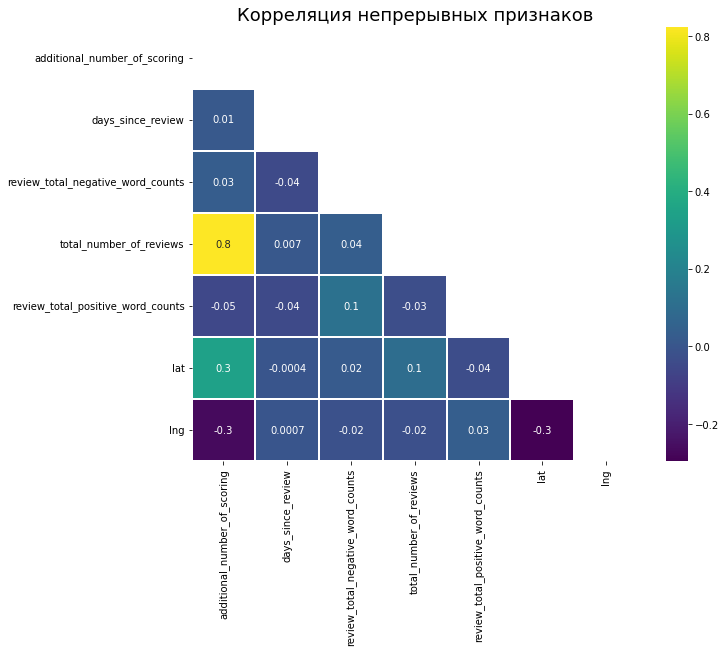

In [47]:
fig_, ax_ = plt.subplots(figsize=(10, 8))
corr = data[cols_num].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1g')
ax_.set_title('Корреляция непрерывных признаков', fontsize=18)
plt.show()

Удаление признака'additional_number_of_scoring' ухудшило модель, так что не буду его удалять

In [48]:
data = data.drop(['additional_number_of_scoring'], axis = 1)

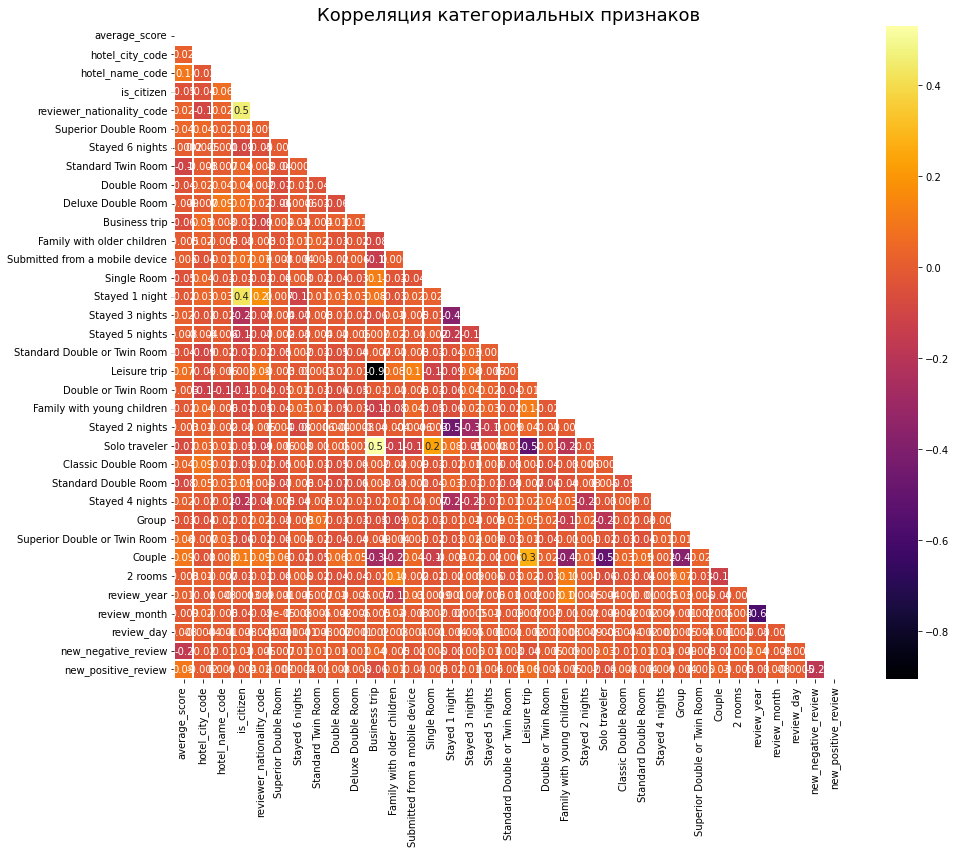

In [49]:
#Построим тепловую диаграмму корреляции категориальных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[cols_cat].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='inferno',
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=18)
plt.show()

In [50]:
data = data.drop(['Business trip'], axis = 1)

#### 3.3 Анализ значимости признаков

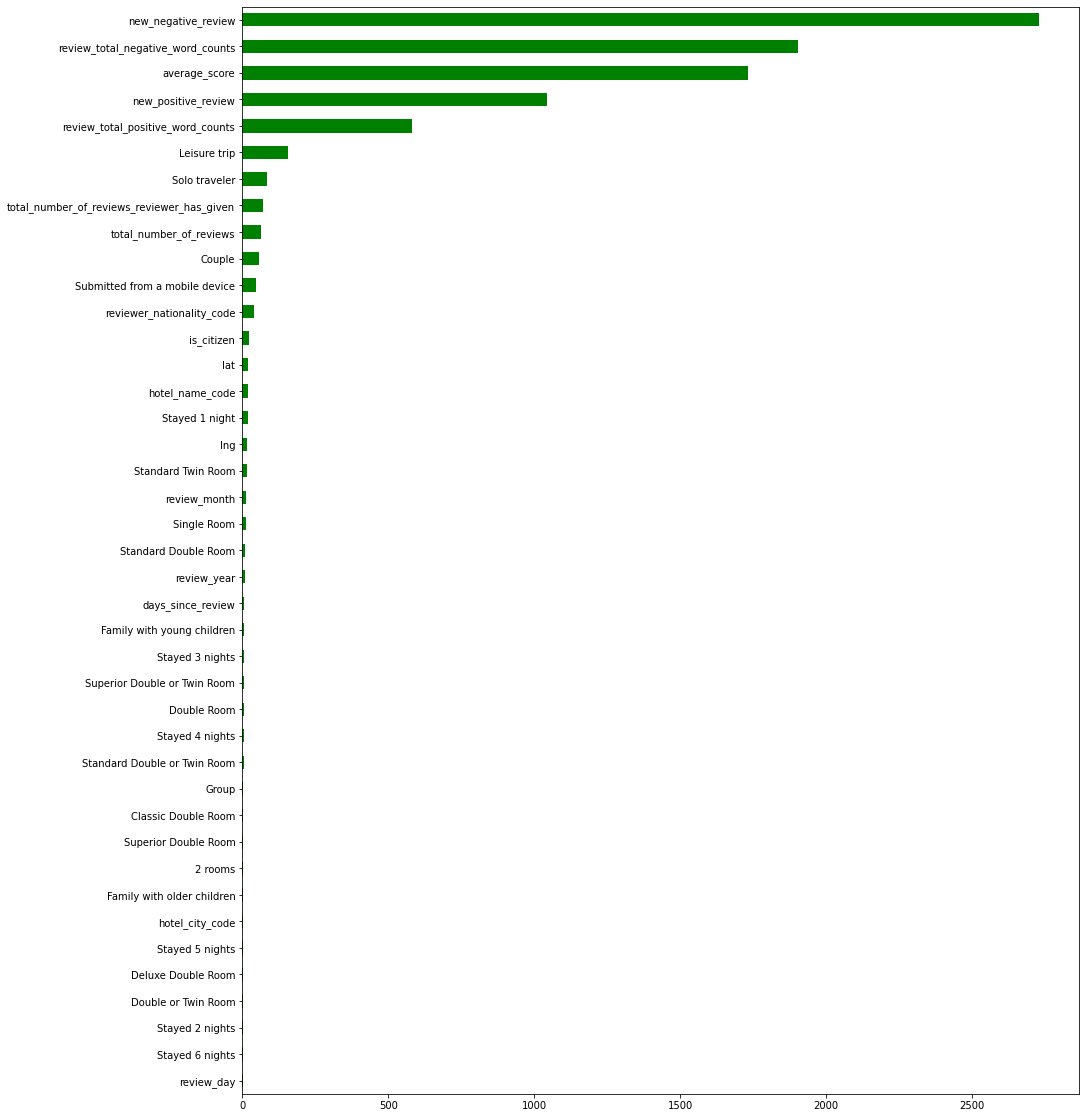

In [51]:
#Для оценки значимости признаков (суммарно по всей совокупности) будем использовать тест ANOVA:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
from sklearn.feature_selection import f_classif # anova
# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [52]:
imp_num

review_day                                       0.912439
Stayed 6 nights                                  1.481344
Stayed 2 nights                                  1.502834
Double or Twin Room                              1.926536
Deluxe Double Room                               1.991454
Stayed 5 nights                                  2.840302
hotel_city_code                                  2.892148
Family with older children                       3.241622
2 rooms                                          3.279698
Superior Double Room                             3.848460
Classic Double Room                              3.881538
Group                                            3.965822
Standard Double or Twin Room                     4.349216
Stayed 4 nights                                  4.373988
Double Room                                      5.235690
Superior Double or Twin Room                     6.878886
Stayed 3 nights                                  7.032822
Family with yo

Удалив признаки со значимостью < 5, результат вышел хуже. Поэтому в итоговой версии удалять их не буду.

In [53]:
"""cols_for_del = [
    'review_day', 
    'Stayed 6 nights', 
    'Stayed 2 nights', 
    'Double or Twin Room', 
    'Deluxe Double Room', 
    'Stayed 5 nights', 
    'hotel_city_code', 
    'Family with older children', 
    '2 rooms', 
    'Superior Double Room', 
    'Classic Double Room', 
    'Group', 
    'Standard Double or Twin Room', 
    'Stayed 4 nights']
data.drop(cols_for_del, axis = 1, inplace=True)"""

"cols_for_del = [\n    'review_day', \n    'Stayed 6 nights', \n    'Stayed 2 nights', \n    'Double or Twin Room', \n    'Deluxe Double Room', \n    'Stayed 5 nights', \n    'hotel_city_code', \n    'Family with older children', \n    '2 rooms', \n    'Superior Double Room', \n    'Classic Double Room', \n    'Group', \n    'Standard Double or Twin Room', \n    'Stayed 4 nights']\ndata.drop(cols_for_del, axis = 1, inplace=True)"

In [54]:
print(f'Итоговое получившееся количество признаков: {len(data.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Итоговое получившееся количество признаков: 43
(включая столбец "Sample" и целевой столбец)


## 4. Обучение модели

#### 4.1 Разбиение данных на тестовую и обучающие выборки

In [55]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

#### 4.2 Обучение модели

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [60]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


#### 4.3 Анализ результатов модели и подготовка данных к отправке

In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.924709642178506


<AxesSubplot:>

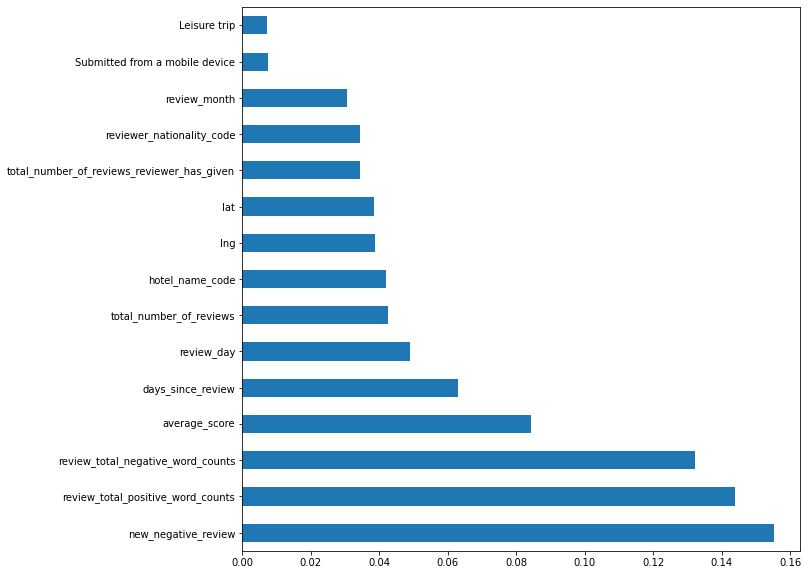

In [62]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [63]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,hotel_city_code,...,Stayed 5 nights,Submitted from a mobile device,Solo traveler,Stayed 4 nights,Group,review_year,review_month,review_day,new_negative_review,new_positive_review
72218,-0.285714,0.142857,-0.483687,-0.411765,-0.285714,0.579545,-1.822049,1.839709,0.0,1.0,...,0.0,-1.0,1.0,0.0,0.0,0.0,-1.2,0.533333,0.0,0.0
14930,1.000000,-0.333333,-0.641925,0.176471,0.285714,0.338068,-0.793249,0.461510,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.6,0.133333,0.0,0.0
18540,-0.285714,0.333333,-0.405383,-0.529412,0.000000,0.926136,-0.002194,-0.035561,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.4,0.533333,0.0,0.0
68739,0.428571,-0.142857,-0.710033,-0.529412,1.714286,0.917614,-0.001927,-0.035935,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,-1.0,0.4,0.733333,0.0,0.0
21171,-1.857143,0.904762,2.835237,0.235294,0.571429,0.852273,0.000584,-0.008648,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,-1.0,0.6,0.266667,0.0,0.0
42656,0.285714,0.333333,0.873573,-0.647059,0.714286,-0.693182,-3.061769,0.430721,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.6,0.000000,0.0,-1.0
90154,0.714286,0.095238,-0.634584,1.294118,0.000000,-0.042614,-0.998951,3.279001,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.933333,0.0,0.0
35638,-1.428571,-0.428571,-0.635400,-0.294118,0.857143,-0.795455,-0.795555,0.456864,0.0,2.0,...,0.0,-1.0,0.0,0.0,0.0,1.0,-0.4,0.400000,-1.0,0.0
45647,0.285714,-0.428571,-0.493475,1.235294,-0.285714,-0.017045,-0.006697,-0.006747,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.333333,-1.0,0.0
110311,0.285714,-0.428571,-0.357667,1.352941,3.142857,-0.769886,-0.989294,3.289603,0.0,3.0,...,0.0,-1.0,0.0,0.0,0.0,1.0,-0.4,-0.200000,-1.0,0.0


In [64]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [65]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [66]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [67]:
predict_submission

array([8.788, 6.401, 7.991, ..., 7.965, 9.477, 7.076])

In [68]:
list(sample_submission)

['reviewer_score', 'id']

In [69]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.788,488440
1,6.401,274649
2,7.991,374688
3,9.751,404352
4,9.480,451596
5,8.747,302161
6,7.828,317079
7,7.632,13963
8,8.499,159785
9,7.623,195089
